In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

## Бутстрап-оценка метрики

На примере дорожного трафика Чикаго протестируем стабильность модели

In [8]:
df = pd.read_csv("Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Regions_20241120.csv")
df.columns = [col.lower().strip() for col in df.columns]

df.head()

,region,region_id,west,east,south,north,description,current_speed,last_updated
0,Edge Water-Uptown,4,-87.674590,-87.646438,41.960669,41.997946,Montrose to Devon. Ravenswood to Lake Shore,19.09,2024-11-20 13:40:27.0
1,Ashburn,22,-87.747456,-87.672980,41.728472,41.764066,91st to 71st. Cicero to Damen,29.32,2024-11-20 13:40:27.0
2,Irving Park-Avondale-North Ctr,6,-87.747456,-87.674590,41.931841,41.960669,Diversey to Montrose. Cicero to Ravenswood,21.82,2024-11-20 13:40:27.0
3,Bridgeport-McKinley-Lower West,15,-87.685372,-87.636322,41.822792,41.866129,Pershing to Roosevel. Western to Stewart,24.55,2024-11-20 13:40:27.0
4,South West Side,18,-87.747456,-87.683730,41.764066,41.822792,71st to Pershing. Cicero to Western,23.86,2024-11-20 13:40:27.0


In [9]:
X = df[["west", "east", "south", "north"]]
y = df["current_speed"]

In [10]:
model = LinearRegression()

n_iterations = 1000
rmse_scores = []

# random_state всегда разный, но фиксированный для воспроизводимости
# если его зафиксировать один и тот же, то выборки будут одни те же!!

for i in range(n_iterations):
    # Создаем бутстрап-выборку с возвратом
    # аналог в pandas: df.sample(frac=1.0, replace=True, random_state=42)

    X_resampled, y_resampled = resample(X, y, replace=True, random_state=i)

    # Оставляем невыбранные данные для оценки 
    X_oob = X[~X.index.isin(X_resampled.index)]
    y_oob = y[~y.index.isin(y_resampled.index)]

    model = LinearRegression()
    model.fit(X_resampled, y_resampled)

    y_oob_pred = model.predict(X_oob)

    # Рассчитываем RMSE для отложенных выборок
    rmse = np.sqrt(mean_squared_error(y_oob, y_oob_pred))
    rmse_scores.append(rmse)

Средний RMSE: 3.0755447872220194
Стандартное отклонение RMSE: 0.6508361622178808
95% доверительный интервал RMSE: [1.8836552372726234, 4.469892524225103]


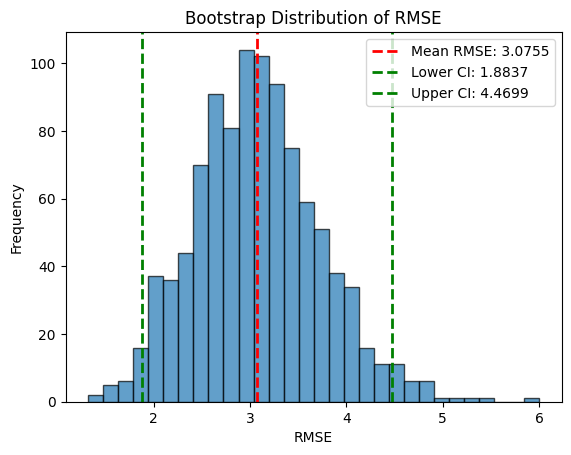

In [11]:
# Оценка распределения RMSE
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)

# Рассчитываем доверительный интервал (95%)
ci_lower = np.percentile(rmse_scores, 2.5)
ci_upper = np.percentile(rmse_scores, 97.5)

print(f"Средний RMSE: {rmse_mean}")
print(f"Стандартное отклонение RMSE: {rmse_std}")
print(f"95% доверительный интервал RMSE: [{ci_lower}, {ci_upper}]")

# Визуализация распределения RMSE
plt.hist(rmse_scores, bins=30, edgecolor="k", alpha=0.7)
plt.axvline(
    rmse_mean,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean RMSE: {rmse_mean:.4f}",
)
plt.axvline(
    ci_lower,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Lower CI: {ci_lower:.4f}",
)
plt.axvline(
    ci_upper,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Upper CI: {ci_upper:.4f}",
)
plt.legend()
plt.title("Bootstrap Distribution of RMSE")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.show()

## АВ тестирование с помощью бутстрепа

Допустим, часть датасета с трафиком до введения новых законов и часть после. Задача - оценить изменение средней скорости

### Случайное разделение исходного датасета

In [13]:
speed = df["current_speed"]
speed_before = speed.sample(frac=0.5, random_state=42)
speed_after = speed.loc[~speed.index.isin(speed_before.index)]

means_diff = speed_after.mean() - speed_before.mean()
print("Средние до и после", speed_before.mean(), speed_after.mean())
print("Разность средних", means_diff)

Средние до и после 23.473571428571432 25.459333333333333
Разность средних 1.985761904761901


Сформулируем гипотезы (от формулировки зависит что именно мы будем проверять)
- H_0 скорость **не увеличилась**
- H_1 скорость увеличилась после принятия нового закона

In [15]:
# бутстреп анализ с перемешиванием

num_boots = 10_000
counter = 0
for i in range(num_boots):
    random_sample = pd.concat([speed_before, speed_after]).sample(
        frac=1, random_state=i, replace=True
    )
    sample_before = random_sample.iloc[:len(speed_before)]
    sample_after = random_sample.iloc[len(speed_before):]
    random_means_diff = sample_after.mean() - sample_before.mean()
    counter += random_means_diff > means_diff

In [16]:
alpha = 0.05

pvalue = counter/num_boots
print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 0.1112
Не получилось отвергнуть нулевую гипотезу


### Увеличим скорость искуственно

Повторим эксперимент, но добавим случайное число от 1 до 10 в выборке после принятия закона

In [17]:
speed_after_increase = speed_after + np.random.randint(5,10)

means_diff = speed_after_increase.mean() - speed_before.mean()
print("Средние до и после", speed_before.mean(), speed_after_increase.mean())
print("Разность средних", means_diff)

Средние до и после 23.473571428571432 33.45933333333333
Разность средних 9.985761904761901


In [18]:
num_boots = 10000
counter = 0
for i in range(num_boots):
    random_sample = pd.concat([speed_before, speed_after_increase]).sample(
        frac=1, random_state=i, replace=True
    )
    sample_before = random_sample.iloc[:len(speed_before)]
    sample_after = random_sample.iloc[len(speed_before):]
    random_means_diff = sample_after.mean() - sample_before.mean()
    counter += random_means_diff > means_diff


In [19]:
alpha = 0.05

pvalue = counter/num_boots
print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 0.0
Отвергаем нулевую гипотезу


Такой вариант тестирования приведен в тренажере. Но можно не сравнивать внутри цикла, а собрать разность средних в массив и построить доверительный интервал разностей. Если разность ноль попадает в доверительный интервал, то считаем что нет оснований отвергать нулевую гипотезу, и скорость не увеличилась

Следующий пример –– как раз такого типа

## Статистический анализ медицинских данных

Допустим, мы оцениваем эффективность нового препарата по сравнению со стандартным лечением. У нас есть выборка из 200 пациентов: 100 получали новый препарат, а 100 — стандартное лечение. Основной метрикой эффективности является снижение уровня определенного маркера болезни через 6 месяцев.

Сгенерируем искусственные данные:
- Группа нового препарата имеет среднее снижение маркера 12 единиц с стандартным отклонением 5
- Группа стандартного лечения имеет среднее снижение 10 единиц с стандартным отклонением 5

Для оценки сравнительного эффекта, выраженного количественным признаком, используется **разность средних**


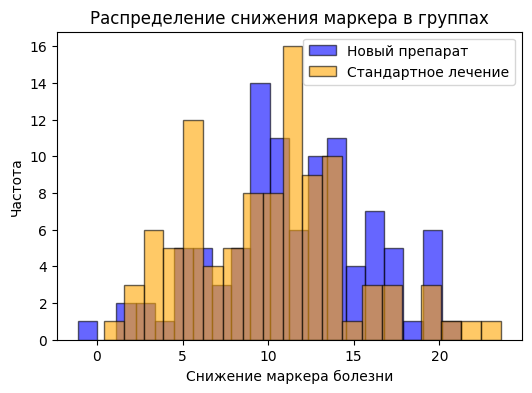

In [20]:
np.random.seed(42)

n_patients = 100
new_treatment = np.random.normal(loc=12, scale=5, size=n_patients)
standard_treatment = np.random.normal(loc=10, scale=5, size=n_patients)

plt.figure(figsize=(6, 4))
plt.hist(
    new_treatment,
    bins=20,
    alpha=0.6,
    color="blue",
    label="Новый препарат",
    edgecolor="black",
)
plt.hist(
    standard_treatment,
    bins=20,
    alpha=0.6,
    color="orange",
    label="Стандартное лечение",
    edgecolor="black",
)
plt.xlabel("Снижение маркера болезни")
plt.ylabel("Частота")
plt.title("Распределение снижения маркера в группах")
plt.legend()
plt.show()

In [21]:
# Вычисляем разницу средних
obs_diff = new_treatment.mean() - standard_treatment.mean()

# Бутстрапирование
n_bootstraps = 10_000
bootstrap_diffs = []

# еще один способ набирать случайные наблюдения через функцию numpy. проблема - нет воспроизводимости
for _ in range(n_bootstraps):
    new_sample = np.random.choice(new_treatment, size=n_patients, replace=True)
    standard_sample = np.random.choice(standard_treatment, size=n_patients, replace=True)
    bootstrap_diffs.append(new_sample.mean() - standard_sample.mean())

# Доверительный интервал (95%)
ci_lower, ci_upper = np.percentile(bootstrap_diffs, [2.5, 97.5])

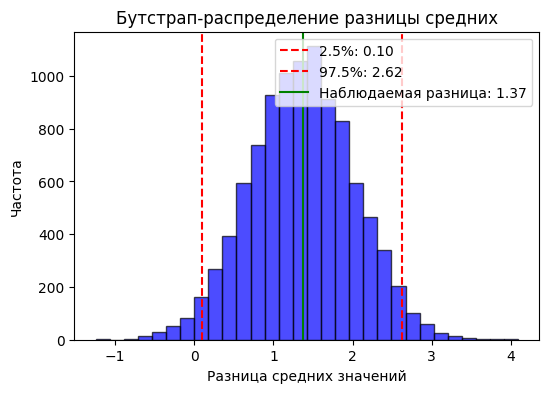

Наблюдаемая разница средних: 1.37
95%-й доверительный интервал: [0.10, 2.62]


In [22]:
# Визуализация бутстрап-распределения разницы средних
plt.figure(figsize=(6, 4))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(ci_lower, color="red", linestyle="dashed", label=f"2.5%: {ci_lower:.2f}")
plt.axvline(ci_upper, color="red", linestyle="dashed", label=f"97.5%: {ci_upper:.2f}")
plt.axvline(
    obs_diff,
    color="green",
    linestyle="solid",
    label=f"Наблюдаемая разница: {obs_diff:.2f}",
)
plt.xlabel("Разница средних значений")
plt.ylabel("Частота")
plt.title("Бутстрап-распределение разницы средних")
plt.legend()
plt.show()

# Вывод результатов
print(f"Наблюдаемая разница средних: {obs_diff:.2f}")
print(f"95%-й доверительный интервал: [{ci_lower:.2f}, {ci_upper:.2f}]")

Доверительный интервал для **разности средних** дает возможность судить о величине различий между группами.

Истинная разность средних может находиться в любой точке доверительного интервала. Поэтому, если полученный при работе с выборками доверительный интервал содержит нулевое значение, то это значит, что истинная разность средних также может быть равна нулю. Следовательно, не будет оснований отвергнуть нулевую гипотезу. В свою очередь, если доверительный интервал не содержит нуля, можно с заданной уверенностью отказаться от нулевой гипотезы и считать различия статистически значимыми.

Итого при оценке **разности средних**
- Если доверительный интервал не включает 0, это говорит о статистически значимой разнице между группами
- Если интервал содержит 0 (отсутствие разницы), различия могут быть обусловлены случайностью

Этот метод позволяет оценить эффект нового лечения, используя бутстрэп без строгих предположений о распределении данных



# Сравнение с t-тестом

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
np.random.seed(42)

# Группа A: контрольная группа, с нормальным распределением
group_a = np.random.normal(loc=50, scale=10, size=1000)

# Группа B: тестируемая группа, с нормальным распределением (с небольшим сдвигом)
group_b = np.random.normal(loc=52, scale=10, size=1000)

# Создаем DataFrame
data = pd.DataFrame({
    'group': ['A'] * 1000 + ['B'] * 1000,
    'value': np.concatenate([group_a, group_b])
})

# Просмотр первых строк данных
data.head()


,group,value
0,A,54.967142
1,A,48.617357
2,A,56.476885
3,A,65.230299
4,A,47.658466


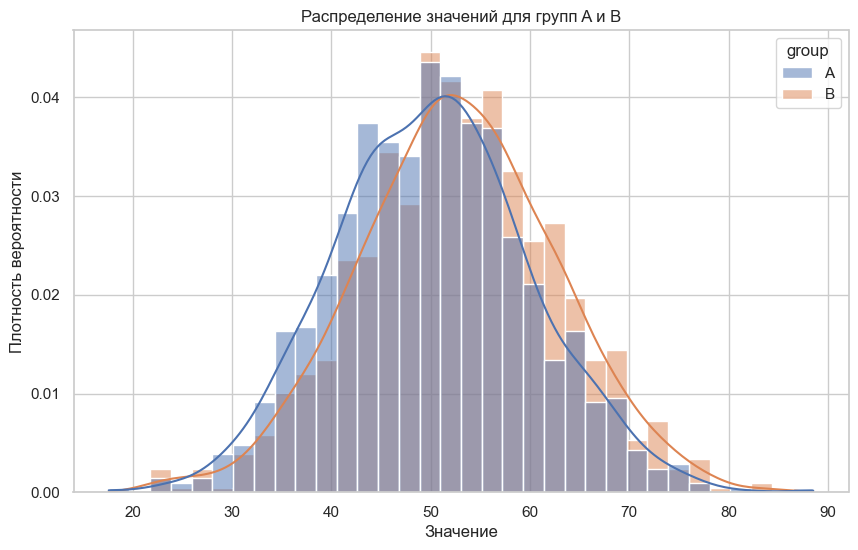

In [24]:
# Визуализация распределений для группы A и группы B
plt.figure(figsize=(10,6))

sns.histplot(data=data, x="value", hue="group", kde=True, stat="density", common_norm=False)
plt.title("Распределение значений для групп A и B")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.show()


In [25]:
# Проведение t-теста для независимых выборок
t_stat, p_value = stats.ttest_ind(group_a, group_b)

# Выводим результаты t-теста
print(f"p-значение: {p_value:.3f}")

# Интерпретируем результаты
if p_value < 0.05:
    print("Мы отвергаем нулевую гипотезу: есть статистически значимая разница между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет статистически значимой разницы между группами A и B.")


p-значение: 0.000
Мы отвергаем нулевую гипотезу: есть статистически значимая разница между группами A и B.


In [28]:
def bootstrap_statistic(data1, data2, n_iterations=10000):
    """
    Функция для выполнения бутстрап-оценки разницы между средними двух выборок.

    :param data1: Первая выборка.
    :param data2: Вторая выборка.
    :param n_iterations: Количество бутстрап-итераций.
    :return: Массив разниц средних для каждой бутстрап-выборки.
    """
    # Сохраняем оригинальные выборки
    diff_means = []

    # Бутстрап-процесс
    for _ in range(n_iterations):
        # Создаем выборки с возвращением
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)

        # Вычисляем разницу средних для каждой бутстрап-выборки
        diff_means.append(np.mean(sample1) - np.mean(sample2))

    return np.array(diff_means)

# Запуск бутстрапа
diff_means_bootstrap = bootstrap_statistic(group_a, group_b)

# Вычисление доверительного интервала
conf_interval = np.percentile(diff_means_bootstrap, [2.5, 97.5])
obs_diff = group_a.mean() - group_b.mean()


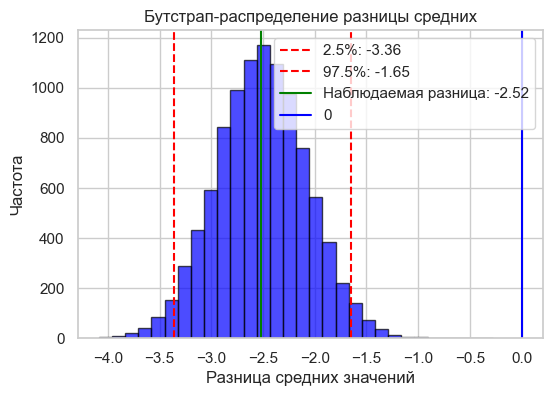

Наблюдаемая разница средних: -2.52
95%-й доверительный интервал: [0.10, 2.62]


In [29]:
# Визуализация бутстрап-распределения разницы средних
plt.figure(figsize=(6, 4))
plt.hist(diff_means_bootstrap, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(conf_interval[0], color="red", linestyle="dashed", label=f"2.5%: {conf_interval[0]:.2f}")
plt.axvline(conf_interval[1], color="red", linestyle="dashed", label=f"97.5%: {conf_interval[1]:.2f}")
plt.axvline(
    obs_diff,
    color="green",
    linestyle="solid",
    label=f"Наблюдаемая разница: {obs_diff:.2f}",
)
plt.axvline(
    0,
    color="blue",
    linestyle="solid",
    label=f"0",
)
plt.xlabel("Разница средних значений")
plt.ylabel("Частота")
plt.title("Бутстрап-распределение разницы средних")
plt.legend()
plt.show()

# Вывод результатов
print(f"Наблюдаемая разница средних: {obs_diff:.2f}")
print(f"95%-й доверительный интервал: [{ci_lower:.2f}, {ci_upper:.2f}]")